In [1]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt, patches
from scipy.interpolate import interp1d

from src.data.loaders import aisy
from src.data.preprocess.hw import full_states, hamming_weights
from src.dlla.hw import prepare_traces_dl, dlla_known_p
from src.dlla.berg import make_mlp
from src.tools.cache import cache_np
from src.tools.lists import find
from src.tools.plotter import init_plots, store_sns
from src.trace_set.database import Database
from src.trace_set.set_hw import TraceSetHW
from src.tvla.cri import rho_test

init_plots()

In [2]:
TRACES = cache_np("aisy_traces")

IN_FILE = h5py.File(aisy.aes.tvla, "r")
# TRACES = np.array(IN_FILE['traces_group/traces'], dtype=np.int8)
TVLA_BYTE = IN_FILE['traces_group/metadata']['tvla_byte'].astype(bool)[:, 0]

PLAINTEXT = IN_FILE['traces_group/metadata']['plaintext'].astype(int)
CIPHERTEXT = IN_FILE['traces_group/metadata']['ciphertext'].astype(int)

KEY = IN_FILE['traces_group/metadata']['key'].astype(int)

In [3]:
PVS = cache_np("aisy", rho_test, TRACES, TVLA_BYTE)

In [4]:
np.min(PVS[0])

0.0

In [5]:
START, END = 93000, 95000

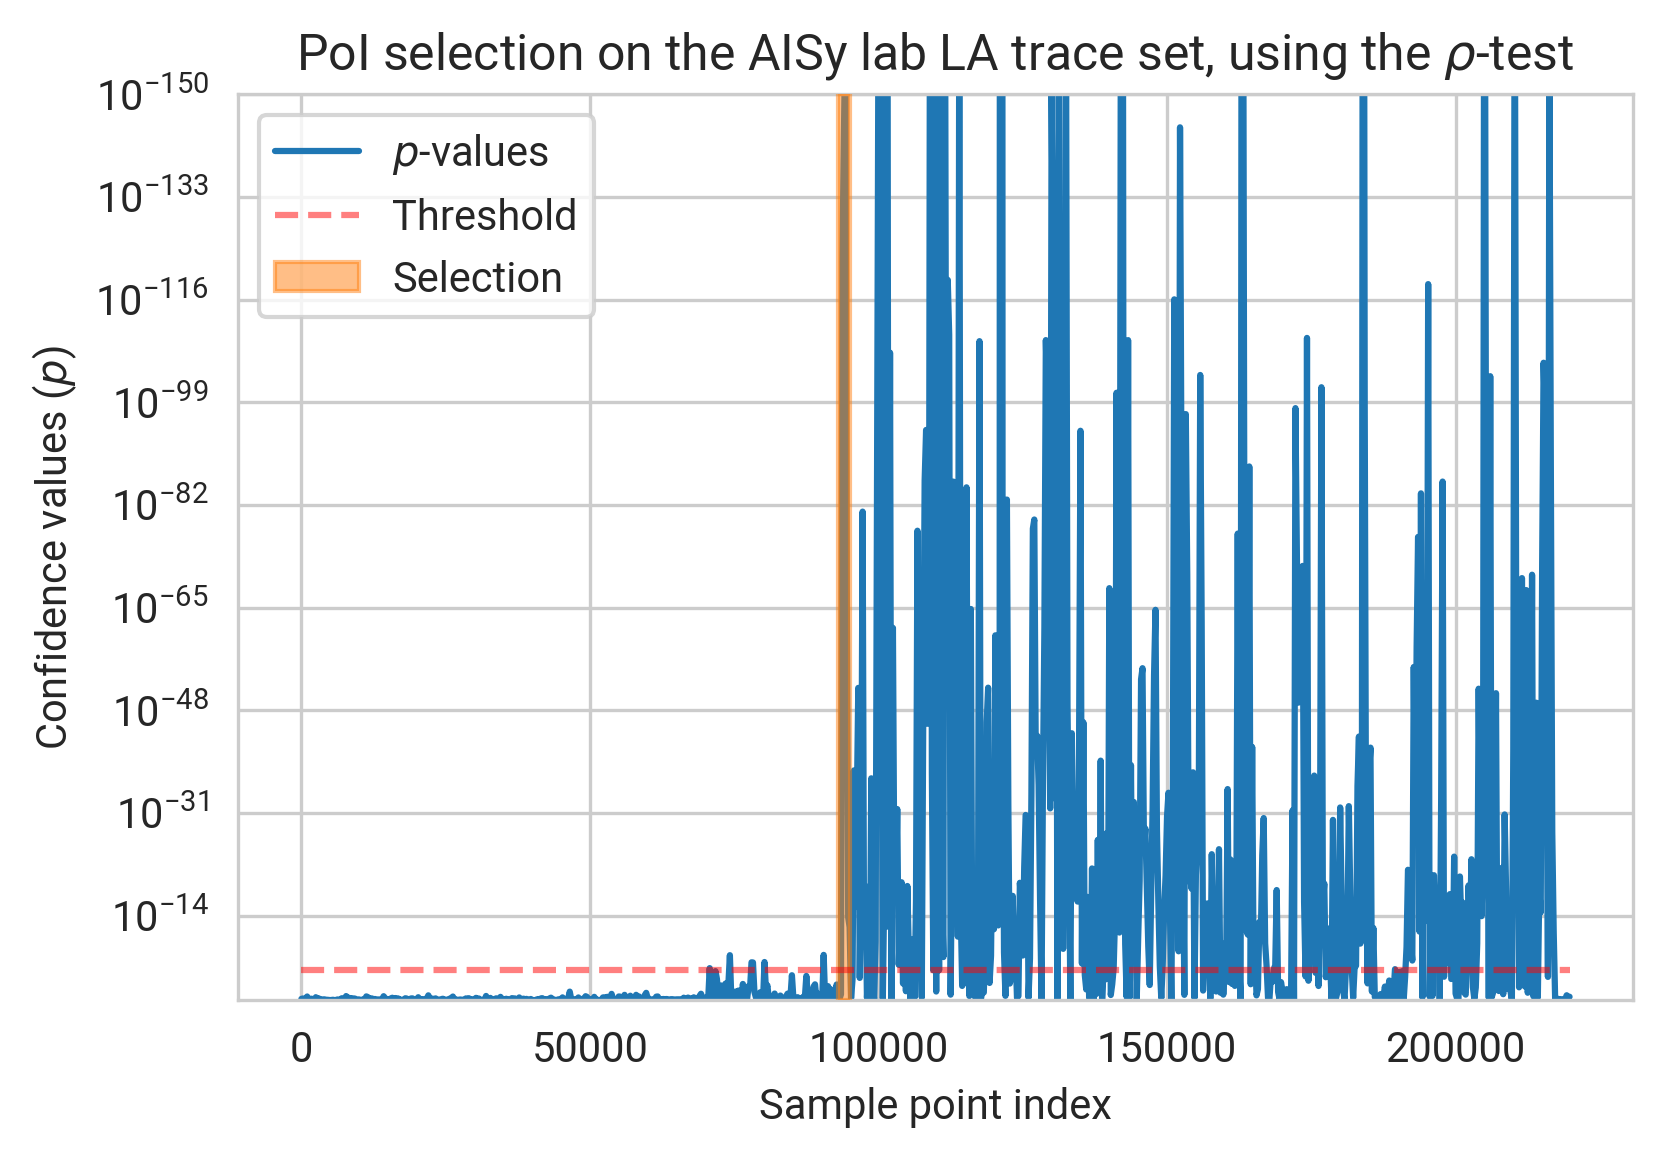

In [6]:
IX = np.arange(len(PVS[0]), step=250)
G = sns.lineplot(data=pd.DataFrame({"$p$-values": PVS[0][::250]}, index=IX))

HIGHLIGHT = sns.color_palette()[1]
plt.axvspan(START, END, color=HIGHLIGHT, alpha=.5, zorder=100)
sns.lineplot(y=[10 ** -5] * len(IX), x = IX, color="#FF000080", linestyle="--", label="Threshold", zorder=101)
G.set(yscale="log", ylim=(1, 10 ** -150), xlabel="Sample point index", ylabel="Confidence values ($p$)",
      title="PoI selection on the AISy lab LA trace set, using the $\\rho$-test")

handles, labels = G.get_legend_handles_labels()
patch = patches.Patch(color=HIGHLIGHT, alpha=.5, label='Selection')
handles.append(patch)
plt.legend(handles=handles)
store_sns(G, "poi-aisy")

In [ ]:
G = sns.lineplot(data={"$\\rho$-test": PVS[0]})
G.invert_yaxis()
G.set(yscale="log", xlim=(START, END))

In [ ]:
STATES = full_states(PLAINTEXT, KEY)

In [ ]:
TARGET_ROUND = 4 # Fifth round
TARGET_BIT = 0

TARGET_STATE = STATES[:, TARGET_ROUND, TARGET_BIT]

In [ ]:
POI_TRACES = TRACES[:, START:END]

In [ ]:
PROFILING_MASK = np.ones(len(POI_TRACES), dtype=bool)
PROFILING_MASK[2::3] = 0

X, Y = POI_TRACES[PROFILING_MASK], TARGET_STATE[PROFILING_MASK]
X_ATT, Y_ATT = POI_TRACES[~PROFILING_MASK], TARGET_STATE[~PROFILING_MASK]

TraceSetHW(Database.aisy).create(X, Y, X_ATT, Y_ATT)

In [ ]:
TRACE_SET = TraceSetHW(Database.aisy)
X9, Y9, X9_ATT, Y9_ATT = prepare_traces_dl(*TRACE_SET.profile(), *TRACE_SET.attack())
MDL9 = make_mlp(X9, Y9)
DLLA9_P = dlla_known_p(MDL9, X9_ATT, Y9_ATT)

DLLA9_P